In [47]:
# libaries
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import permutations, combinations
from random import shuffle, random, randint, uniform, sample
import numpy as np
import statistics
import pandas as pd
import seaborn as SNs
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
# generate (x,y) coordinates and returns a dictionary where cities are the key,
# and (x,y) coordinates are the values
def generate_cities(names):
  coordinates = {city: (randint(1,20), randint(1,20)) for city in names}
  return coordinates

# we need to extract the (x,y) coordinates from the dictionary
def extract_coordinates(coord_dict):
    x = [coord[0] for coord in coord_dict.values()]
    y = [coord[1] for coord in coord_dict.values()]
    return x, y

In [4]:
# get the euclidean distance between two cities
def distance_between_cities(city1, city2):
    # takes in name of city1 and city2 from city_coords dict and gets (x,y) values
    city1cord = city_coords[city1]
    city2cord = city_coords[city2]
    norm = np.linalg.norm(np.array(city1cord) - np.array(city2cord))
    return norm

#================================================================================

# total distance of a candidate solution TSP
def total_distance(individual):
    # ex: [0,1,2,3,4,5,6,7,8,9]
    total = 0
    for i in range(len(cities_names)):
        if (i == len(individual) - 1):
            total += distance_between_cities(individual[i], individual[0])
        else:
            total += distance_between_cities(individual[i], individual[i+1])
    return total

#================================================================================

# create initial population of candidate solutions
def initial_population(city_names, size):
    population_solutions = []
    possible_permutations = list(permutations(city_names))
    perm_ids = sample(range(0, len(possible_permutations)), size)
    for i in perm_ids:
        population_solutions.append(list(possible_permutations[i]))
    return population_solutions

#================================================================================

# scores the population of candidate solutions
# higher fitness scores means better solutions to the TSP problem
def fitness(population):
    distances_of_population = []
    for i in range(0, len(population)):
        distances_of_population.append(total_distance(population[i]))

    max_distance = max(distances_of_population)
    fitness_scores = max_distance - distances_of_population
    population_fitness_prob = fitness_scores / sum(fitness_scores)
    return population_fitness_prob

#================================================================================

# candidate solutions with higher fitness scores are more likely to be chosen for reproduction
# use roulette wheel
def selection(population, fitness_probs):
    # returns i-th individual from the population
    population_fitness_cumsum = np.cumsum(fitness_probs)
    prob = uniform(0,1)
    selected_individual_id = 0
    for i, val in enumerate(population_fitness_cumsum):
        if prob <= val:
            selected_individual_id = i
            break # exit loop if condition is met
    return population[i]

#================================================================================

# 2 parent solutions and produce 2 children solutions
def crossover(parent1, parent2):
    cut = randint(1, len(parent1) - 1)
    child1 = parent1[0:cut]
    child2 = parent2[0:cut]

    for city in parent2:
        if city not in child1:
            child1.append(city)

    for city in parent1:
        if city not in child2:
            child2.append(city)

    return child1, child2

#================================================================================

# mutate the child solution
def mutate(child):
    cut = len(cities_names) - 1
    id1 = randint(0,cut)
    id2 = randint(0,cut)
    temp = child[id1]
    child[id1] = child[id2]
    child[id2] = temp
    return child

In [5]:
# the genetic algorithm
def ga(city_names, size, generations, crossover_rate, mutation_rate):
    # create the starting population of candidate solutions
    starting_population = initial_population(city_names, size)

    # calculate the fitness scores of the starting population
    scores = fitness(starting_population)

    # select the individuals that are going to be parents and reproduce
    parent_list = []
    for i in range(0, int(crossover_rate * size)): # 80% of population size will reproduce
        parent_list.append(selection(starting_population, scores))

    # create children with your list of parents -- 2 parents produce 2 children
    child_list = []
    for i in range(0, len(parent_list), 2):
        child1, child2 = crossover(parent_list[i], parent_list[i+1])

        # we mutate the child1
        rate = uniform(0,1)
        if (1-mutation_rate) < rate:
            child1 = mutate(child1)

        # we mutate child2
        rate = uniform(0,1)
        if (1-mutation_rate) < rate:
            child2 = mutate(child2)

        child_list.append(child1)
        child_list.append(child2)

    # list of parent & child solutions
    mixed_list = parent_list + child_list

    # get the scores of the mixed list and figure out which ones are the best scores
    scores = fitness(mixed_list)
    sorted_scores_ids = np.argsort(scores)[::-1] # returns a list of indices sorted in descending order
    best_scores_ids = sorted_scores_ids[0:size]

    # get the best mixed individuals
    best_mixed_list = []
    for i in best_scores_ids:
        best_mixed_list.append(mixed_list[i])

    # we do this for "n" generations with the best mixed list of parents and children
    for i in range(0, generations):
        scores = fitness(best_mixed_list)

        parent_list = []
        for i in range(0, int(crossover_rate * size)):
            parent_list.append(selection(best_mixed_list, scores))

        child_list = []
        for i in range(0, len(parent_list), 2):
            child1, child2 = crossover(parent_list[i], parent_list[i+1])

            # we mutate the child1
            rate = uniform(0,1)
            if (1-mutation_rate) < rate:
                child1 = mutate(child1)

            # we mutate child2
            rate = uniform(0,1)
            if (1-mutation_rate) < rate:
                child2 = mutate(child2)

            child_list.append(child1)
            child_list.append(child2)

        mixed_list = parent_list + child_list
        scores = fitness(mixed_list)
        sorted_scores_ids = np.argsort(scores)[::-1]
        best_scores_ids = sorted_scores_ids[0: int(0.8 * size)] # take 80% of the best indicies

        best_mixed_list = []
        for i in best_scores_ids:
            best_mixed_list.append(mixed_list[i])

        # take 20% of the old population and place it into best mixed list to keep the size
        old_population_ids = [randint(0, (size - 1)) for j in range(int(0.2 * size))]
        for i in range(0, len(old_population_ids)):
            best_mixed_list.append(starting_population[i])

        # randomly shuffle the new population
        shuffle(best_mixed_list)

    return best_mixed_list

In [58]:
# the data
cities_names  = ["Gliwice", "Cairo", "Rome", "Krakow", "Paris", "Alexandria", "Berlin", "Tokyo", "Hong Kong", "Rio"]
city_coords = generate_cities(cities_names)
x = list(extract_coordinates(data)[0])
y = list(extract_coordinates(data)[1])

# the initialization of the TSP solver
size = 250
generations = 200
crossover_rate = 0.8
mutation_rate = 0.2

# get the best solutions provided from genetic algorithm function for each generation
best_solutions = ga(cities_names, size, generations, crossover_rate, mutation_rate)

total_distance_of_solutions = []
for i in range(0, size):
    total_distance_of_solutions.append(round(total_distance(best_solutions[i]), 3))

mincost_id = np.argmin(total_distance_of_solutions)

# solution to the TSP problem
shortest_path = best_solutions[mincost_id]
min_distance = min(total_distance_of_solutions)

id_of_first_shortest_path = total_distance_of_solutions.index(min_distance) + 1

print("shortest path:", shortest_path)
print("min distance:", min_distance)
print("number of generations it look to reach optimum solution:", id_of_first_shortest_path)

shortest path: ['Cairo', 'Berlin', 'Rome', 'Paris', 'Krakow', 'Gliwice', 'Rio', 'Alexandria', 'Tokyo', 'Hong Kong']
min distance: 57.296
number of generations it look to reach optimum solution: 2


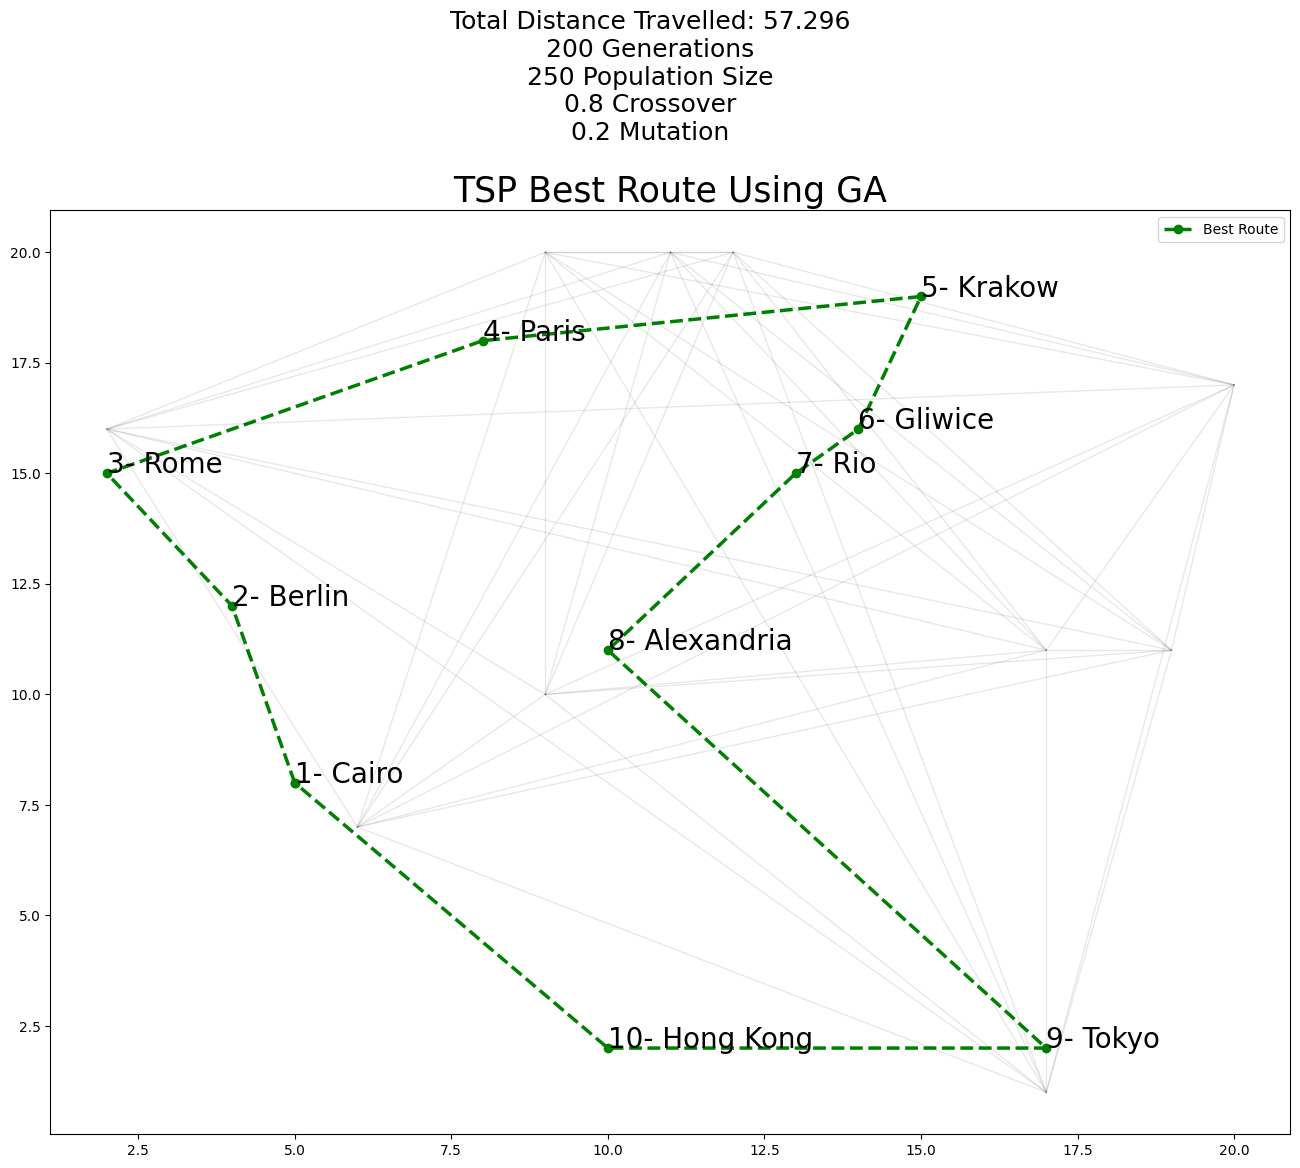

In [59]:
# plot the solution to the TSP problem
x_shortest = []
y_shortest = []
for city in shortest_path:
    x_value, y_value = city_coords[city]
    x_shortest.append(x_value)
    y_shortest.append(y_value)

x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

fig, ax = plt.subplots()
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)

plt.title(label="TSP Best Route Using GA",
          fontsize=25,
          color="k")

str_params = '\n'+str(generations)+' Generations\n'+str(size)+' Population Size\n'+str(crossover_rate)+' Crossover\n'+str(mutation_rate)+' Mutation'
plt.suptitle("Total Distance Travelled: "+
             str(round(min_distance, 3)) +
             str_params, fontsize=18, y = 1.047)

for i, txt in enumerate(shortest_path):
    ax.annotate(str(i+1)+ "- " + txt, (x_shortest[i], y_shortest[i]), fontsize= 20)

fig.set_size_inches(16, 12)
# plt.grid(color='k', linestyle='dotted')
plt.savefig('solution.png')
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import PillowWriter

# initialize the plot with specified axes
fig, ax = plt.subplots()
line, = ax.plot([], [], '--go', label='Best Route', linewidth=2.5)
plt.legend()

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)

# add a text label to display the current generation number
generation_text = plt.text(0.5, 0.95, '', transform=ax.transAxes, ha="center", fontsize=10)

# function to update the plot for each frame of the animation
def update(frame):
    x_values = []
    y_values = []
    for city in best_solutions[frame]:
        x_value, y_value = city_coords[city]
        x_values.append(x_value)
        y_values.append(y_value)

    x_values.append(x_values[0])
    y_values.append(y_values[0])

    line.set_data(x_values, y_values)

    # update total distance and generation number labels
    generation_text.set_text(f"Generation: {frame + 1}") #[ADDED THIS -- REMOVE LATER]
    plt.title(f"Total Distance Travelled: {round(total_distance(best_solutions[frame]), 3)}", fontsize=20, color="k")

    return line,

# number of frames (generations) for the animation
num_frames = len(best_solutions)

# set axes limits to match the desired configuration
plt.xlim(min(x) - 2, max(x) + 2)
plt.ylim(min(y) - 2, max(y) + 2)

# create the animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=500, blit=True)

HTML(ani.to_html5_video())
ani.save('animation.gif', writer=PillowWriter(fps=10))
